# Amazon Bedrock boto3 Prerequisites

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

---

In this demo notebook, we demonstrate how to use the [`boto3` Python SDK](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to work with [Amazon Bedrock](https://aws.amazon.com/bedrock/) Foundation Models.

---

## Prerequisites

Run the cells in this section to install the packages needed by the notebooks in this workshop. ⚠️ You will see pip dependency errors, you can safely ignore these errors. ⚠️

IGNORE ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

In [1]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"


     |████████████████████████████████| 139 kB 8.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 19.0 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 57.0 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 1.0 MB/s  eta 0:00:011
     |████████████████████████████████| 548 kB 40.2 MB/s eta 0:00:01
     |████████████████████████████████| 738 kB 51.3 MB/s eta 0:00:01
     |████████████████████████████████| 229 kB 44.6 MB/s eta 0:00:01
     |████████████████████████████████| 143 kB 49.3 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 20.8 MB/s eta 0:00:011
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.9
    Uninstalling urllib3-1.26.9:
      Successfully uninstalled urllib3-1.26.9
  Attempting uninstall: python-dateutil
    Found existing installation: pyth

In [30]:
!pip install -U boto3

In [1]:
import os
os.environ["AWS_DEFAULT_REGION"] = "us-west-2"

---

## Create the boto3 client

Interaction with the Bedrock API is done via the AWS SDK for Python: [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

#### Use different clients
The boto3 provides different clients for Amazon Bedrock to perform different actions. The actions for [`InvokeModel`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModel.html) and [`InvokeModelWithResponseStream`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModelWithResponseStream.html) are supported by Amazon Bedrock Runtime where as other operations, such as [ListFoundationModels](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_ListFoundationModels.html), are handled via [Amazon Bedrock client](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_Operations_Amazon_Bedrock.html).


#### Use the default credential chain

If you are running this notebook from [Amazon Sagemaker Studio](https://aws.amazon.com/sagemaker/studio/) and your Sagemaker Studio [execution role](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) has permissions to access Bedrock you can just run the cells below as-is. This is also the case if you are running these notebooks from a computer whose default AWS credentials have access to Bedrock.



In [2]:
import json
import os
import sys

import boto3

boto3_bedrock = boto3.client('bedrock')

#### Validate the connection

We can check the client works by trying out the `list_foundation_models()` method, which will tell us all the models available for us to use 

In [3]:
boto3_bedrock.list_foundation_models()


{'ResponseMetadata': {'RequestId': '6182d169-bb8f-48d3-abb1-560e81b9538b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 29 Apr 2024 00:37:56 GMT',
   'content-type': 'application/json',
   'content-length': '22356',
   'connection': 'keep-alive',
   'x-amzn-requestid': '6182d169-bb8f-48d3-abb1-560e81b9538b'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-tg1-large',
   'modelId': 'amazon.titan-tg1-large',
   'modelName': 'Titan Text Large',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities': ['TEXT'],
   'responseStreamingSupported': True,
   'customizationsSupported': [],
   'inferenceTypesSupported': ['ON_DEMAND'],
   'modelLifecycle': {'status': 'ACTIVE'}},
  {'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-embed-g1-text-02',
   'modelId': 'amazon.titan-embed-g1-text-02',
   'modelName': 'Titan Text Embeddings v2',
   'providerName': 'Amazon',
   'inp

---

## `InvokeModel` body and output

The `invoke_model()` method of the Amazon Bedrock runtime client (`InvokeModel` API) will be the primary method we use for most of our Text Generation and Processing tasks - whichever model we're using.

Although the method is shared, the format of input and output varies depending on the foundation model used - as described below:

### Amazon Titan Large

#### Input
```json
{   
    "inputText": "<prompt>",
    "textGenerationConfig" : { 
        "maxTokenCount": 512,
        "stopSequences": [],
        "temperature": 0.1,  
        "topP": 0.9
    }
}
```

#### Output

```json
{
    "inputTextTokenCount": 613,
    "results": [{
        "tokenCount": 219,
        "outputText": "<output>"
    }]
}
```

### Anthropic Claude

#### Input

```json
{
    "prompt": "\n\nHuman:<prompt>\n\nAnswer:",
    "max_tokens_to_sample": 300,
    "temperature": 0.5,
    "top_k": 250,
    "top_p": 1,
    "stop_sequences": ["\n\nHuman:"]
}
```

#### Output

```json
{
    "completion": "<output>",
    "stop_reason": "stop_sequence"
}
```

### Stability AI Stable Diffusion XL

#### Input

```json
{
    "text_prompts": [
        {"text": "this is where you place your input text"}
    ],
    "cfg_scale": 10,
    "seed": 0,
    "steps": 50
}
```

#### Output

```json
{ 
    "result": "success", 
    "artifacts": [
        {
            "seed": 123, 
            "base64": "<image in base64>",
            "finishReason": "SUCCESS"
        },
        //...
    ]
}
```

---

## Common inference parameter definitions

### Randomness and Diversity

Foundation models generally support the following parameters to control randomness and diversity in the 
response.

**Temperature** – Large language models use probability to construct the words in a sequence. For any 
given next word, there is a probability distribution of options for the next word in the sequence. When 
you set the temperature closer to zero, the model tends to select the higher-probability words. When 
you set the temperature further away from zero, the model may select a lower-probability word.

In technical terms, the temperature modulates the probability density function for the next tokens, 
implementing the temperature sampling technique. This parameter can deepen or flatten the density 
function curve. A lower value results in a steeper curve with more deterministic responses, and a higher 
value results in a flatter curve with more random responses.

**Top K** – Temperature defines the probability distribution of potential words, and Top K defines the cut 
off where the model no longer selects the words. For example, if K=50, the model selects from 50 of the 
most probable words that could be next in a given sequence. This reduces the probability that an unusual 
word gets selected next in a sequence.
In technical terms, Top K is the number of the highest-probability vocabulary tokens to keep for Top-
K-filtering - This limits the distribution of probable tokens, so the model chooses one of the highest-
probability tokens.

**Top P** – Top P defines a cut off based on the sum of probabilities of the potential choices. If you set Top 
P below 1.0, the model considers the most probable options and ignores less probable ones. Top P is 
similar to Top K, but instead of capping the number of choices, it caps choices based on the sum of their 
probabilities.
For the example prompt "I hear the hoof beats of ," you may want the model to provide "horses," 
"zebras" or "unicorns" as the next word. If you set the temperature to its maximum, without capping 
Top K or Top P, you increase the probability of getting unusual results such as "unicorns." If you set the 
temperature to 0, you increase the probability of "horses." If you set a high temperature and set Top K or 
Top P to the maximum, you increase the probability of "horses" or "zebras," and decrease the probability 
of "unicorns."

### Length

The following parameters control the length of the generated response.

**Response length** – Configures the minimum and maximum number of tokens to use in the generated 
response.

**Length penalty** – Length penalty optimizes the model to be more concise in its output by penalizing 
longer responses. Length penalty differs from response length as the response length is a hard cut off for 
the minimum or maximum response length.

In technical terms, the length penalty penalizes the model exponentially for lengthy responses. 0.0 
means no penalty. Set a value less than 0.0 for the model to generate longer sequences, or set a value 
greater than 0.0 for the model to produce shorter sequences.

### Repetitions

The following parameters help control repetition in the generated response.

**Repetition penalty (presence penalty)** – Prevents repetitions of the same words (tokens) in responses. 
1.0 means no penalty. Greater than 1.0 decreases repetition.

---

## Try out the models

With some theory out of the way, let's see the models in action! Run the cells below to see basic, synchronous example invocations for each model:

In [4]:
import boto3
import botocore
import json

bedrock_runtime = boto3.client('bedrock-runtime')


### Amazon Titan Large

In [9]:
# If you'd like to try your own prompt, edit this parameter!
prompt_data = """Command: Write me a blog about making strong business decisions as a leader.

Blog:
"""


Next, we will construct the body with the `prompt_data` above, and add a optional parameters like `topP` and `temperature`:

In [19]:
try:

    body = json.dumps({"inputText": prompt_data, "textGenerationConfig" : {"topP":0.95, "temperature":0.2}})
    modelId = "amazon.titan-tg1-large"
    accept = "application/json"
    contentType = "application/json"

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    print(response_body.get("results")[0].get("outputText"))

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


Title: Navigating Complex Business Decisions with Confidence

Introduction:
As a leader, making decisions that impact the success of your business can be daunting. However, with the right approach and mindset, you can navigate complex business decisions with confidence and lead your organization toward growth and prosperity. In this blog, we will explore some key strategies for making strong business decisions as a leader.

Step 1: Gather Information
Before making any decision, it is essential to gather as much information as possible. This includes internal data, market trends, customer feedback, and insights from your team. The more you understand the context and implications of your


In [20]:
type(response)

dict

In [21]:
response

{'ResponseMetadata': {'RequestId': '4d7dc01f-46af-49eb-8506-51c9f3ce6f19',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sun, 28 Apr 2024 13:14:47 GMT',
   'content-type': 'application/json',
   'content-length': '801',
   'connection': 'keep-alive',
   'x-amzn-requestid': '4d7dc01f-46af-49eb-8506-51c9f3ce6f19',
   'x-amzn-bedrock-invocation-latency': '3228',
   'x-amzn-bedrock-output-token-count': '128',
   'x-amzn-bedrock-input-token-count': '20'},
  'RetryAttempts': 0},
 'contentType': 'application/json',
 'body': <botocore.response.StreamingBody at 0x7ca768ac0880>}

In [22]:
response_body

{'inputTextTokenCount': 20,
 'results': [{'tokenCount': 128,
   'outputText': 'Title: Navigating Complex Business Decisions with Confidence\n\nIntroduction:\nAs a leader, making decisions that impact the success of your business can be daunting. However, with the right approach and mindset, you can navigate complex business decisions with confidence and lead your organization toward growth and prosperity. In this blog, we will explore some key strategies for making strong business decisions as a leader.\n\nStep 1: Gather Information\nBefore making any decision, it is essential to gather as much information as possible. This includes internal data, market trends, customer feedback, and insights from your team. The more you understand the context and implications of your',
   'completionReason': 'LENGTH'}]}

### Anthropic Claude

In [23]:
# If you'd like to try your own prompt, edit this parameter!
prompt_data = """Human: Write me a blog about making strong business decisions as a leader.

Assistant:
"""


In [24]:
body = json.dumps({"prompt": prompt_data, "max_tokens_to_sample": 500})
modelId = "anthropic.claude-instant-v1"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    print(response_body.get("completion"))

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


 Here is a draft blog post on making strong business decisions as a leader:

Title: 5 Tips for Making Strong Business Decisions as a Leader

As a business leader, making well-informed decisions is one of the most important parts of your role. Both small day-to-day choices and major strategic decisions can impact the direction and success of your company. Here are some tips for making thoughtful, impactful choices that will strengthen your business:

1. Gather relevant data and insights. Before making any choice, take the time to research key factors like market trends, competitor analysis, customer feedback, and financial implications. Look at both qualitative and quantitative information from various departments and viewpoints. The more informed you are, the better the decision will be.

2. Involve the right people. For important decisions, bring together people from different levels and roles who have valuable expertise related to the choice. Encourage open discussion and diverse per

In [25]:
response

{'ResponseMetadata': {'RequestId': 'be77f1cd-ac85-4c9a-b612-d7cc10bc6b16',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sun, 28 Apr 2024 13:15:22 GMT',
   'content-type': 'application/json',
   'content-length': '2469',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'be77f1cd-ac85-4c9a-b612-d7cc10bc6b16',
   'x-amzn-bedrock-invocation-latency': '7510',
   'x-amzn-bedrock-output-token-count': '460',
   'x-amzn-bedrock-input-token-count': '22'},
  'RetryAttempts': 0},
 'contentType': 'application/json',
 'body': <botocore.response.StreamingBody at 0x7ca768a5fa60>}

In [26]:
response_body

{'completion': ' Here is a draft blog post on making strong business decisions as a leader:\n\nTitle: 5 Tips for Making Strong Business Decisions as a Leader\n\nAs a business leader, making well-informed decisions is one of the most important parts of your role. Both small day-to-day choices and major strategic decisions can impact the direction and success of your company. Here are some tips for making thoughtful, impactful choices that will strengthen your business:\n\n1. Gather relevant data and insights. Before making any choice, take the time to research key factors like market trends, competitor analysis, customer feedback, and financial implications. Look at both qualitative and quantitative information from various departments and viewpoints. The more informed you are, the better the decision will be.\n\n2. Involve the right people. For important decisions, bring together people from different levels and roles who have valuable expertise related to the choice. Encourage open di

### 補足
- 以下にmodel idが記載されている
  - https://docs.aws.amazon.com/bedrock/latest/userguide/model-ids.html
- 公式doc
  - https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-anthropic-claude-messages.html
- prompt technique
  - https://docs.anthropic.com/claude/docs/system-prompts

#### message completion

In [7]:
import boto3
import json
import os
from botocore.exceptions import ClientError
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)


os.environ["AWS_DEFAULT_REGION"] = "us-west-2"

In [2]:
def generate_message(bedrock_runtime, model_id, body):
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get("body").read())
    return response_body

In [9]:
claude_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 1000,
    "system": "Respond only in Japanese",
    "messages":  [
        {
            "role": "user",
            "content": [{"type": "text", "text": "4月は東京を訪れるのに良い時期ですか？"}]
        }
    ],
    "modelId": "anthropic.claude-3-haiku-20240307-v1:0",
    # "modelId": "anthropic.claude-3-sonnet-20240229-v1:0",
    # "modelId": "anthropic.claude-3-opus-20240229-v1:0"
}

try:
    bedrock_runtime = boto3.client("bedrock-runtime")
    model_id = claude_config.pop("modelId", None)
    body = json.dumps(claude_config)

    response_body = generate_message(bedrock_runtime, model_id, body)
    print(response_body["content"][0]["text"])
except ClientError as err:
    message=err.response["Error"]["Message"]
    logger.error("A client error occurred: %s", message)
    print("A client error occured: " +
        format(message))

はい、4月は東京を訪れるのにとても良い時期です。以下のようなメリットがあります:

- 桜の季節 - 4月は桜の開花時期で、東京の景色が美しくなります。代表的な観光スポットである上野公園や千鳥ヶ淵などで、桜の花見を楽しめます。

- 気候が良い - 春の訪れを感じられる快適な気候です。寒さも和らぎ、まだ暑くなりすぎていないので観光に適しています。

- 混雑が少ない - 夏や冬に比べると観光客が少ないため、主要な観光地やレストランの混雑が少なめです。

- 各種イベントが開催 - 桜祭りや伝統的な季節行事など、4月は様々なイベントが東京で行われます。

ですので、4月の東京訪問は桜を満喫しつつ、混雑を避けて快適に観光できる良い時期だと言えます。ぜひ機会があれば訪れてみてください。


#### multimodal code

In [18]:
import json
import os
import logging
import base64
import boto3

from botocore.exceptions import ClientError

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)


os.environ["AWS_DEFAULT_REGION"] = "us-west-2"

def prepare_multimodal_config(claude_config):
    model_id = claude_config.pop("modelId", None)
    input_image = claude_config.pop("input_image", None)
    input_text = claude_config.pop("input_text", None)

    with open(input_image, "rb") as image_file:
            content_image = base64.b64encode(image_file.read()).decode('utf8')

    message = {
        "role": "user",
        "content": [
            {
                "type": "image",
                "source": {
                    "type": "base64",
                    "media_type": "image/jpeg",
                    "data": content_image
                }
            },
            {
                "type": "text",
                "text": input_text
            }
        ]}

    messages = [message]
    claude_config["messages"] = messages
    body = json.dumps(claude_config)
    return model_id, body

In [20]:
claude_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 1000,
    "system": "Respond only in Japanese",
    "modelId": "anthropic.claude-3-haiku-20240307-v1:0",
    # "modelId": "anthropic.claude-3-sonnet-20240229-v1:0",
    # "modelId": "anthropic.claude-3-opus-20240229-v1:0"
    "input_text": "この画像は何ですか？",
    "input_image": "../imgs/10-overview.png"
}

try:
    bedrock_runtime = boto3.client("bedrock-runtime")
    model_id, body = prepare_multimodal_config(claude_config)

    response_body = generate_message(bedrock_runtime, model_id, body)
    print(response_body["content"][0]["text"])
except ClientError as err:
    message=err.response["Error"]["Message"]
    logger.error("A client error occurred: %s", message)
    print("A client error occured: " +
        format(message))

この画像は、いくつかのAIの機能をアイコンで表現したものです。具体的には以下の5つの機能が描かれています:

1. テキスト生成 - 文書を自動的に生成する機能
2. チャットボット - 会話型のインターフェイスを提供する機能
3. 要約 - 長文書を要約する機能
4. 画像生成 - 画像を自動生成する機能
5. 質問回答 - 質問に対して回答を提供する機能

これらはAIが持つ代表的な機能の一部を視覚的に表現したものと言えます。AI技術の多様性と可能性を示唆する興味深い図解だと思います。


### Stability Stable Diffusion XL

In [21]:
prompt_data = "a landscape with trees"
body = json.dumps({
    "text_prompts": [{"text": prompt_data}],
    "cfg_scale": 10,
    "seed": 20,
    "steps": 50
})
modelId = "stability.stable-diffusion-xl-v1"
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    print(response_body["result"])
    print(f'{response_body.get("artifacts")[0].get("base64")[0:80]}...')

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


success
iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAAABYmVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


**Note:** The output is a [base64 encoded](https://docs.python.org/3/library/base64.html) string of the image data. You can use any image processing library (such as [Pillow](https://pillow.readthedocs.io/en/stable/)) to decode the image as in the example below:

```python
import base64
import io
from PIL import Image

base_64_img_str = response_body.get("artifacts")[0].get("base64")
image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
```

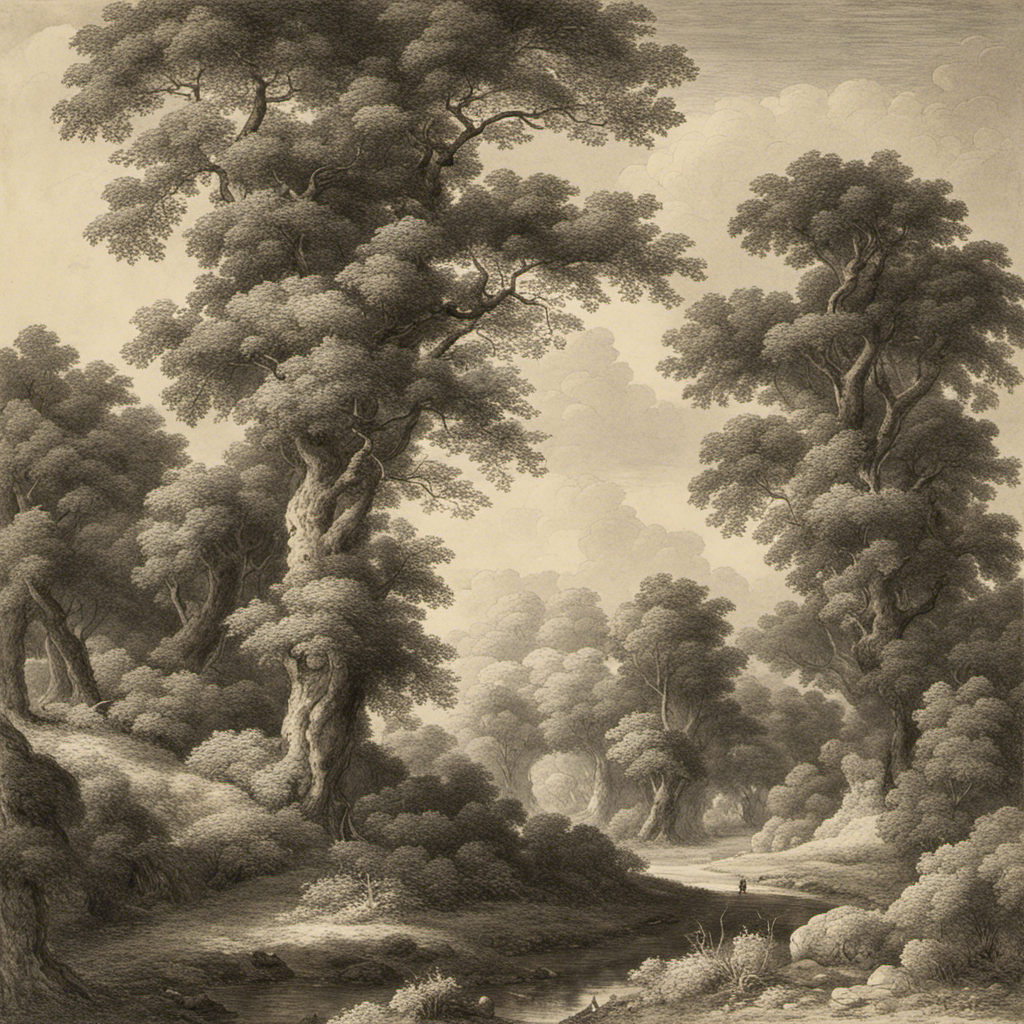

In [22]:
import base64
import io
from PIL import Image

base_64_img_str = response_body.get("artifacts")[0].get("base64")
image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image

## Generate streaming output

For large language models, it can take noticeable time to generate long output sequences. Rather than waiting for the entire response to be available, latency-sensitive applications may like to **stream** the response to users.

Run the code below to see how you can achieve this with Bedrock's `invoke_model_with_response_stream()` method - returning the response body in separate chunks.

In [23]:
from IPython.display import clear_output, display, display_markdown, Markdown
prompt_data = """Command: Write me a blog about making strong business decisions as a leader.

Blog:
"""

body = json.dumps({"inputText": prompt_data})
modelId = "amazon.titan-tg1-large"  # (Change this, and the request body, to try different models)
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model_with_response_stream(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    stream = response.get('body')
    output = []

    if stream:
        for event in stream:
            chunk = event.get('chunk')
            if chunk:
                chunk_obj = json.loads(chunk.get('bytes').decode())
                if 'outputText' in chunk_obj:
                    text = chunk_obj.get('outputText', None)
                    print(text,end='')
                    if not text :
                        break
                    #text = chunk_obj['outputText']
                    clear_output(wait=True)
                    output.append(text)
                    display_markdown(Markdown(''.join(output)))

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


As a leader, making strong business decisions is crucial for the success of your organization. Here are some key strategies to help you make informed decisions that will lead to positive outcomes:

Define your goals and objectives: Before making any decision, it's important to define what you want to achieve. This will help you stay focused and ensure that your decisions are aligned with your organization's long-term vision.

Gather relevant information: Collect all relevant information about the decision you need to make. This may include data, market trends, customer feedback, and internal metrics. Analyze the information carefully to identify any potential risks or benefits

### Anthropic Claude (messages API)

In [24]:
# If you'd like to try your own prompt, edit this parameter!
prompt_data = """Human: Write me 500 word paragraph about making strong business decisions as a leader.

Assistant:
"""


In [25]:
messages_API_body = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 512,
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt_data
                }
            ]
        }
    ]
}

In [26]:
from IPython.display import clear_output, display, display_markdown, Markdown

body = json.dumps(messages_API_body)
modelId = "anthropic.claude-v2"  # (Change this to try different model versions)
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model_with_response_stream(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )

    stream = response.get('body')


    output = []

    if stream:
        for event in stream:
            chunk = event.get('chunk')
            if chunk:
                chunk_obj = json.loads(chunk.get('bytes').decode())
                if 'delta' in chunk_obj:
                    delta_obj = chunk_obj.get('delta', None)
                    if delta_obj:
                        text = delta_obj.get('text', None)
                        print(text,end='')
                        if not text :
                            break
                    # output.append(text[0]) if type(text) is list and len(text)>0 else output.append('')
                    # display_markdown(Markdown(text))

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


Here is a 499 word paragraph on making strong business decisions as a leader:

As a leader in business, the decisions you make can have a major impact on your company and employees. It is crucial to approach key decisions carefully and thoughtfully. Before making any major choice, take time to gather all relevant information and data. Analyze the pros and cons, potential risks, and possible rewards of various options. Consider both short-term and long-term implications. Get input from trusted advisors like your management team, but own the final call yourself. 

When facing difficult choices, stay focused on your core values, business objectives, and what is best for the company as a whole. Avoid decisions that seem unethical or driven solely by emotion. Remain objective and keep the big picture in mind. With major decisions, the process is as important as the outcome. Explain your thinking to those impacted and be transparent about how you arrived at the decision.

Implement decisions

## Generate embeddings

Use text embeddings to convert text into meaningful vector representations. You input a body of text 
and the output is a (1 x n) vector. You can use embedding vectors for a wide variety of applications. 
Bedrock currently offers Titan Embeddings for text embedding that supports text similarity (finding the 
semantic similarity between bodies of text) and text retrieval (such as search).

At the time of writing you can use `amazon.titan-embed-text-v1` as embedding model via the API. The input text size is 8192 tokens and the output vector length is 1536.

To use a text embeddings model, use the InvokeModel API operation or the Python SDK.
Use InvokeModel to retrieve the vector representation of the input text from the specified model.



#### Input

```json
{
    "inputText": "<text>"
}
```

#### Output

```json
{
    "embedding": []
}
```


Let's see how to generate embeddings of some text:

In [ ]:
prompt_data = "Amazon Bedrock supports foundation models from industry-leading providers such as \
AI21 Labs, Anthropic, Stability AI, and Amazon. Choose the model that is best suited to achieving \
your unique goals."


In [27]:
body = json.dumps({"inputText": prompt_data})
modelId = "amazon.titan-embed-text-v1"  # (Change this to try different embedding models)
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    embedding = response_body.get("embedding")
    print(f"The embedding vector has {len(embedding)} values\n{embedding[0:3]+['...']+embedding[-3:]}")

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


The embedding vector has 1536 values
[0.91796875, -0.65625, 0.03540039, '...', 0.38085938, -0.053955078, -0.087402344]


## Next steps

In this notebook we showed some basic examples of invoking Amazon Bedrock models using the AWS Python SDK. You're now ready to explore the other labs to dive deeper on different use-cases and patterns.